# Tempest Extreme experiment with NextGEMS data

This is trying to work with the intake catalog and using the regridder. 


In [1]:
import sys
sys.path.append('../../')

from aqua import Reader
from aqua.reader import catalogue
#catalogue(catalog_file='../../config/catalog.yaml');

import os
from datetime import datetime
import pandas as pd
from functionsTCs import *


IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	
	- interpolated_global	
	- interpolated_np	
	- interpolated_sp	
	- interpolated_sp_ci	
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	
	- interpolated_global	
	- interpolated_np	
	- interpolated_sp	
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	

FESOM	tco3999-ng5	2.5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- np	nearest-neighbor interpolation to lat-lon grid
	- interpolated_global2d	
	- interpolated_global_TS	
	- interpolated_global_UV	
	- interpolated_np	
	- interpolated_sp	
	- original_2d	original 2d output
	- original_3d	original 3d output
FESOM	tco2559-ng5	5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- interpolated_global2d	
	- interpolated_global_TS	
	- interpolated_global_UV	
	- interpolated_np	
	- interpolated_sp	
	- original_2d	orig

In [2]:
import xarray as xr
import os
import subprocess
from time import time
from glob import glob
from datetime import datetime, timedelta
from functionsTCs import *

# path to input directory
indir='/home/b/b382216/scratch/regrid_intake'
tmpdir='/home/b/b382216/scratch/tmpdir_intake'

boxdim=10

# variables to be stored
varlist = ['psl', 'uas', 'vas']

# dicitonary with the original filenames
original_dictionary = {'psl': 'msl', 'uas': '10u', 'vas': '10v' }

t1=0
t2=6*4*4 # 15 days

initial_date=datetime(2020, 8, 20, 0, 0, 0)

# loop on timerecords
for t in range(t1, t2, 6): 

    tttt = initial_date + timedelta(hours=t)
    tstep = tttt.strftime('%Y%m%dT%H')
    txt_file = os.path.join(tmpdir, 'tempest_output_' + tstep + '.txt')

    tempest_dictionary = readwrite_from_intake(model='IFS', exp = 'tco2559-ng5', timestep=tttt)
    tempest_command = run_detect_nodes(tempest_dictionary, tempest_dictionary['fileout'], txt_file)
    tempest_nodes = read_lonlat_nodes(txt_file)
    id = tempest_nodes['date']
    print(id)

    for var in varlist: 
            print(var)

            varname = tempest_dictionary[var]
            varfile = original_dictionary[var]
            # take the LOW res files to find the bug in the reordered tracks later


            fullres_file=os.path.join(indir, f'regrid+{tttt}_{varfile}.nc')
    
            # get the full res field and store the required values around the Nodes
            fullres_field = xr.open_mfdataset(fullres_file)[varname]
            xfield = store_fullres_field(0, fullres_field, tempest_nodes, boxdim)


            store_file = os.path.join(tmpdir, f'TC_{varname}_{id}.nc')
            write_fullres_field(xfield, store_file)
    
    clean_files([netcdf_file])


msl
10u
10v
z


IndexError: list index out of range

In [2]:

# loop on timerecords
for t in range(t1, t2, 6) : 

    tttt = initial_date + timedelta(hours=t)
    tttt = tttt.strftime('%Y%m%dT%H')
    tttt = str(t).zfill(6)
    print(tttt)
    # path definition
    original_file = os.path.join(indir, f'regrid+{tttt}_*.nc')
    netcdf_file = os.path.join(tmpdir, tttt + '.nc')
    txt_file = os.path.join(tmpdir, 'tempest_output_' + tttt + '.txt')

    # read and save the netcdf file to mimic the time lost by the FDB query
    tempest_dictionary = readwrite_from_lowres(original_file, netcdf_file)

     # run tempest extremes
    tempest_command = run_detect_nodes(tempest_dictionary, netcdf_file, txt_file)
    tempest_nodes = read_lonlat_nodes(txt_file)
    id = tempest_nodes['date']
    print(id)


NameError: name 't1' is not defined

In [4]:
    
    for var in varlist: 
        print(var)

        varname = tempest_dictionary[var]
        varfile = original_dictionary[var]
        # take the LOW res files to find the bug in the reordered tracks later


        fullres_file=os.path.join(indir, f'regrid+{tttt}_{varfile}.nc')
   
        # get the full res field and store the required values around the Nodes
        fullres_field = xr.open_mfdataset(fullres_file)[varname]
        xfield = store_fullres_field(0, fullres_field, tempest_nodes, boxdim)


        store_file = os.path.join(tmpdir, f'TC_{varname}_{id}.nc')
        write_fullres_field(xfield, store_file)
  
    clean_files([netcdf_file])


psl


OSError: no files to open

From here on there is the older version which is fully operative. Do no modify

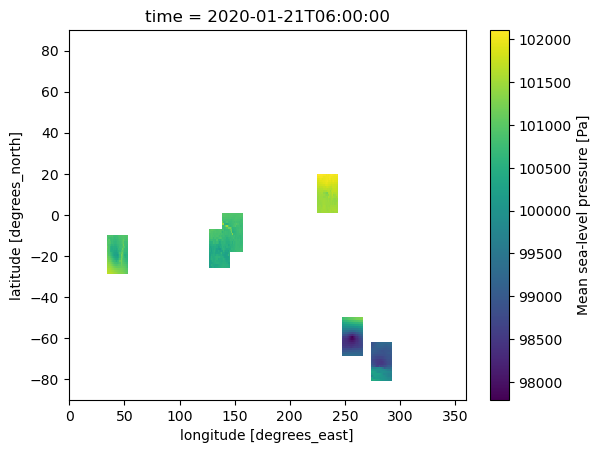

In [1]:
import xarray as xr
import os
import subprocess
from time import time
from glob import glob


from functionsTCs import *

# path to input directory
indir='/home/b/b382216/scratch/regrid'
tmpdir='/home/b/b382216/scratch/tmpdir'
fulldir='/home/b/b382216/scratch/fullres'

time = '000600'
infile = os.path.join(indir, f'regrid+{time}_*.nc')
outfile = os.path.join(tmpdir, time + '.nc')
txtfile = os.path.join(tmpdir, 'output_' + time + '.txt')
mslfile=os.path.join(fulldir, f'ICMGGhqys+{time}_msl.nc')
storefile = os.path.join(tmpdir, 'TC_' + time + '.nc')

# read and save the netcdf file to mimic the time lost by the FDB query
tempest_dictionary = readwrite_from_lowres(infile, outfile)
tempest_command = run_detect_nodes(tempest_dictionary, outfile, txtfile)
tempest_nodes = read_lonlat_nodes(txtfile) 

xfield = xr.open_mfdataset(outfile)['MSL']

# set the dimension in degrees of lon/lat of the box around the TCs centre
boxdim=10
gfield = xfield * 0
for k in range(0, len(tempest_nodes['lon'])) :
    box = lonlatbox(tempest_nodes['lon'][k], tempest_nodes['lat'][k], boxdim)
    gfield = gfield + xr.where((xfield.lon > box[0]) & (xfield.lon < box[1]) & (xfield.lat > box[2]) & (xfield.lat < box[3]), True, False)

xfield = xfield.where(gfield>0)

xfield.plot()

In [1]:
import xarray as xr
import os
import subprocess
from time import time
from glob import glob

from functionsTCs import *

# path to input directory
indir='/home/b/b382216/scratch/regrid'
tmpdir='/home/b/b382216/scratch/tmpdir'
fulldir='/home/b/b382216/scratch/fullres'

boxdim=10

# variables to be stored
varlist = ['psl', 'uas', 'vas']

# dicitonary with the original filenames
original_dictionary = {'psl': 'msl', 'uas': '10u', 'vas': '10v' }

t1=120*4*30*8
t2=(t1+(120*4*14))
#t1=0
#t2=166560

# clear tmpdir
files_to_remove_nc = glob(os.path.join(tmpdir,'*.nc'))
clean_files(files_to_remove_nc)
files_to_remove_txt = glob(os.path.join(tmpdir,'*.txt'))
clean_files(files_to_remove_txt)

# loop on timerecords
for t in range(t1, t2, 120) : 

    tttt = str(t).zfill(6)
    print(tttt)
    # path definition
    original_file = os.path.join(indir, f'regrid+{tttt}_*.nc')
    netcdf_file = os.path.join(tmpdir, tttt + '.nc')
    txt_file = os.path.join(tmpdir, 'tempest_output_' + tttt + '.txt')

    # read and save the netcdf file to mimic the time lost by the FDB query
    tempest_dictionary = readwrite_from_lowres(original_file, netcdf_file)

     # run tempest extremes
    tempest_command = run_detect_nodes(tempest_dictionary, netcdf_file, txt_file)
    tempest_nodes = read_lonlat_nodes(txt_file)
    id = tempest_nodes['date']
    print(id)
    
    for var in varlist: 
        print(var)

        varname = tempest_dictionary[var]
        varfile = original_dictionary[var]
        # now open the full res files
        #fullres_file=os.path.join(indir, f'regrid+{tttt}_{varfile}.nc')
        fullres_file=os.path.join(fulldir, f'ICMGGhqys+{tttt}_{varfile}.nc')
   
        # get the full res field and store the required values around the Nodes
        fullres_field = xr.open_mfdataset(fullres_file)[varname]
        xfield = store_fullres_field(0, fullres_field, tempest_nodes, boxdim)


        store_file = os.path.join(tmpdir, f'TC_{varname}_{id}.nc')
        write_fullres_field(xfield, store_file)
  
    clean_files([netcdf_file])

    ##reinit xfield
    #xfield = 0


115200
2020091600
psl
uas
vas
115320
2020091606
psl
uas
vas
115440
2020091612
psl
uas
vas
115560
2020091618
psl
uas
vas
115680
2020091700
psl
uas
vas
115800
2020091706
psl
uas
vas
115920
2020091712
psl
uas
vas
116040
2020091718
psl
uas
vas
116160
2020091800
psl
uas
vas
116280
2020091806
psl
uas
vas
116400
2020091812
psl
uas
vas
116520
2020091818
psl
uas
vas
116640
2020091900
psl
uas
vas
116760
2020091906
psl
uas
vas
116880
2020091912
psl
uas
vas
117000
2020091918
psl
uas
vas
117120
2020092000
psl
uas
vas
117240
2020092006
psl
uas
vas
117360
2020092012
psl
uas
vas
117480
2020092018
psl
uas
vas
117600
2020092100
psl
uas
vas
117720
2020092106
psl
uas
vas
117840
2020092112
psl
uas
vas
117960
2020092118
psl
uas
vas
118080
2020092200
psl
uas
vas
118200
2020092206
psl
uas
vas
118320
2020092212
psl
uas
vas
118440
2020092218
psl
uas
vas
118560
2020092300
psl
uas
vas
118680
2020092306
psl
uas
vas
118800
2020092312
psl
uas
vas
118920
2020092318
psl
uas
vas
119040
2020092400
psl
uas
vas
119160
202

In [2]:

track_file = os.path.join(tmpdir, 'tempest_track.txt')
filenames = sorted(glob(os.path.join(tmpdir,'tempest_output_*')))

# MAXGAP set to 6h to match the input files res
stitch_string = run_stitch_nodes(filenames, track_file, maxgap = '6h')
# output track. txt OK!

Arguments:
  --in <string> ["full_nodes.txt"] 
  --in_list <string> [""] 
  --in_connect <string> [""] 
  --out <string> ["/home/b/b382216/scratch/tmpdir/tempest_track.txt"] 
  --in_fmt <string> ["lon,lat,slp,wind"] 
  --range <double> [8.000000] (degrees)
  --mintime <string> ["54h"] 
  --time_begin <string> [""] 
  --time_end <string> [""] 
  --min_endpoint_dist <double> [0.000000] (degrees)
  --min_path_dist <double> [0.000000] (degrees)
  --maxgap <string> ["6h"] 
  --threshold <string> ["wind,>=,10.0,10;lat,<=,50.0,10;lat,>=,-50.0,10"] [col,op,value,count;...]
  --caltype <string> ["standard"] (none|standard|noleap|360_day)
  --allow_repeated_times <bool> [false] 
  --out_file_format <string> ["gfdl"] (gfdl|csv|csvnohead)
------------------------------------------------------------
Parsing thresholds
..wind greater than or equal to 10.000000 at least 10 time(s)
..lat less than or equal to 50.000000 at least 10 time(s)
..lat greater than or equal to -50.000000 at least 10 time(s)
.

Get the lon/lat from the Stitch Nodes output .txt file

In [3]:
 # open the output file and extract the required lon/lat
track_file = os.path.join(tmpdir, 'tempest_track.txt')
# reordered_tracks is a dict containing the concatenated (in time) tracks
# at eatch time step are associated all lons/lats
reordered_tracks = reorder_tracks(track_file)

# initialise full_res fields at 0 before the loop

for var in varlist : 
    varname = tempest_dictionary[var]
    xfield = 0
    for id in reordered_tracks.keys():

        print(id)
        fullres_file = os.path.join(tmpdir, f'TC_{varname}_{id}.nc')
        fullres_field = xr.open_mfdataset(fullres_file)[varname]

        # get the full res field and store the required values around the Nodes
        xfield = store_fullres_field(xfield, fullres_field, reordered_tracks[id], boxdim)
       

    print('Storing output')

    # store the file
    store_file = os.path.join(tmpdir, f'tempest_tracks_{varname}.nc')
    write_fullres_field(xfield, store_file)


2020091600
2020091606
2020091612
2020091618
2020091700
2020091706
2020091712
2020091718
2020091800
2020091806
2020091812
2020091818
2020091900
2020091906
2020091912
2020091918
2020092000
2020092006
2020092012
2020092018
2020092100
2020092106
2020092112
2020092118
2020092200
2020092206
2020092212
2020092218
2020092300
2020092306
2020092312
2020092318
2020092400
2020092406
2020092412
2020092418
2020092500
2020092506
2020092512
2020092518
2020092600
2020092606
2020092612
2020092618
2020092700
2020092706
2020092712
2020092718
2020092800
2020092806
2020092812
2020092818
2020092900
2020092906
2020092912
2020092918
Storing output
2020091600
2020091606
2020091612
2020091618
2020091700
2020091706
2020091712
2020091718
2020091800
2020091806
2020091812
2020091818
2020091900
2020091906
2020091912
2020091918
2020092000
2020092006
2020092012
2020092018
2020092100
2020092106
2020092112
2020092118
2020092200
2020092206
2020092212
2020092218
2020092300
2020092306
2020092312
2020092318
2020092400
202009

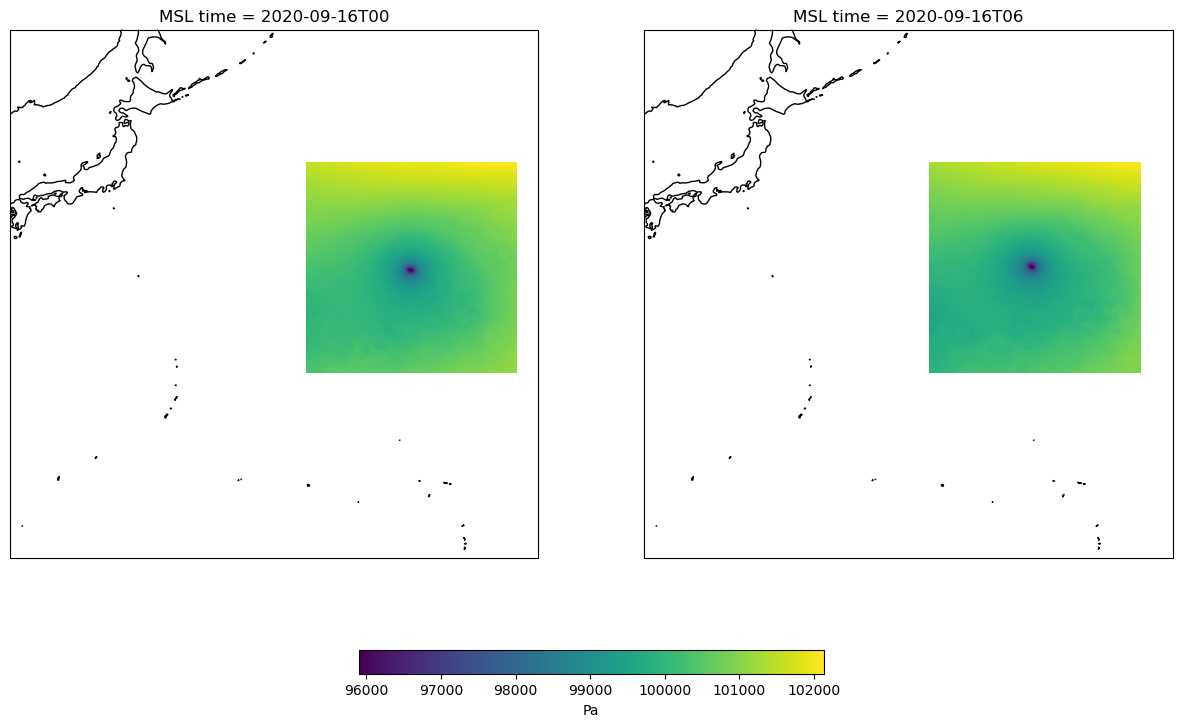

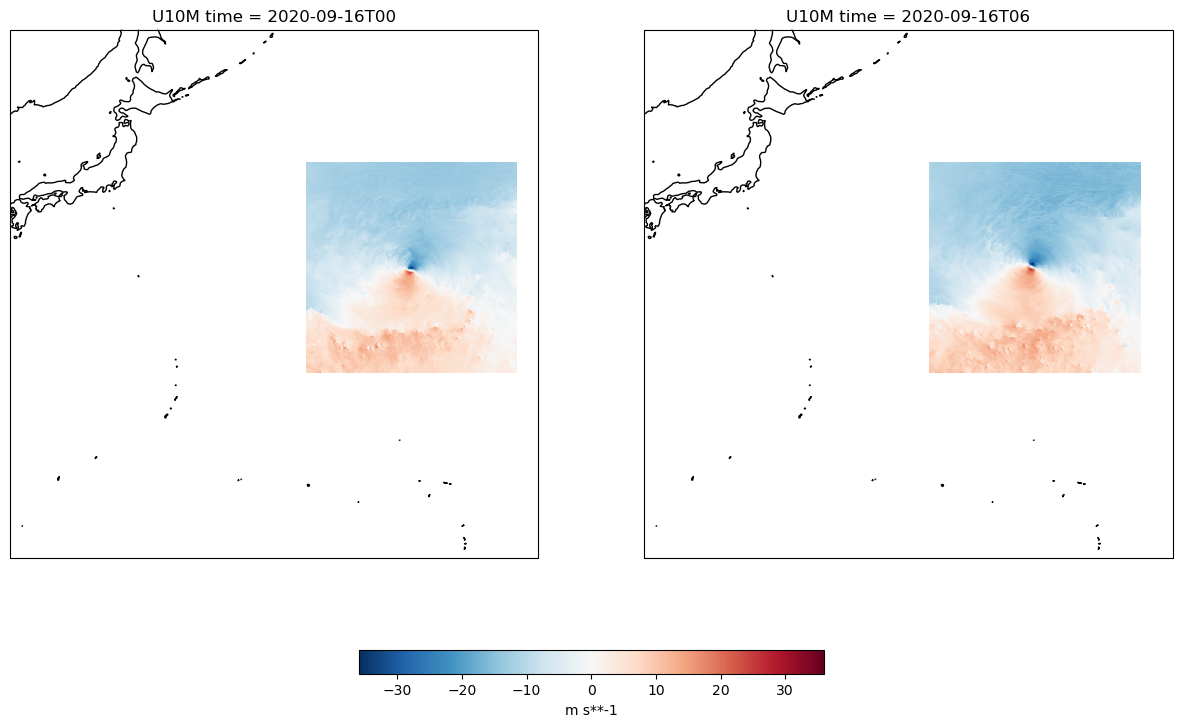

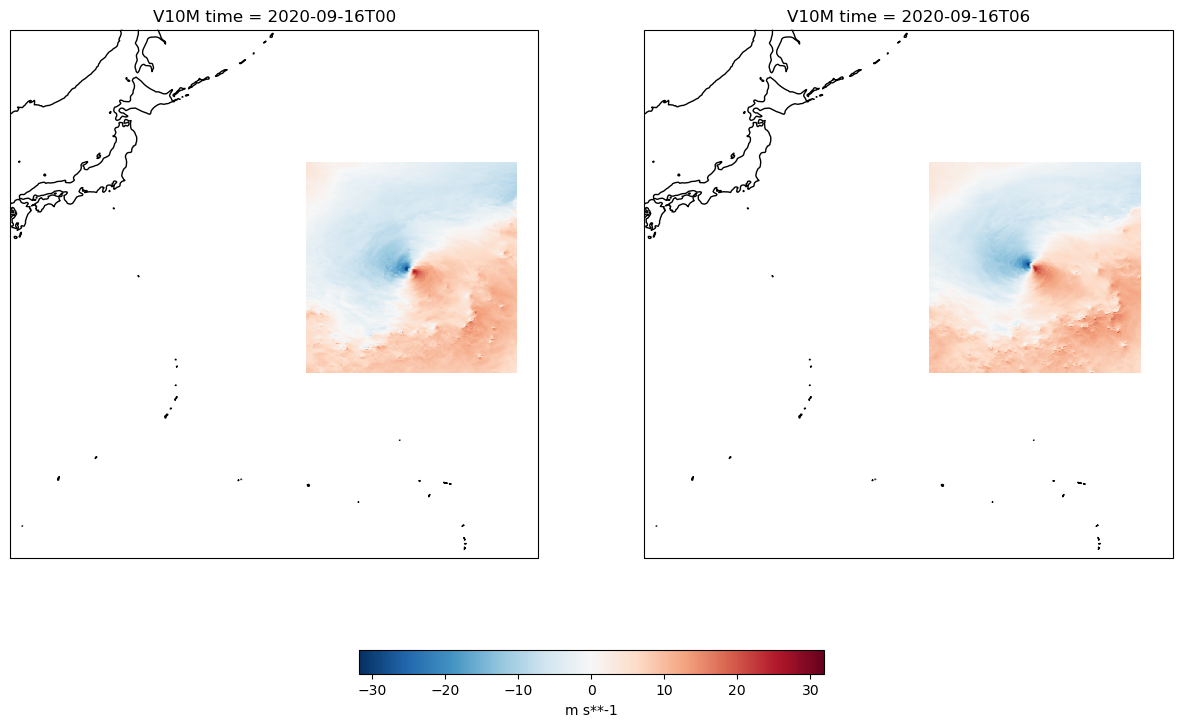

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# set to true if you want only to plot variables without running previous cells
# it needs the tempest_tracks_var.nc file though

only_plotting=True
if only_plotting:
    import xarray as xr
    import os
    from time import time
    from glob import glob
    from functionsTCs import *

    # path to input directory
    indir='/home/b/b382216/scratch/regrid'
    tmpdir='/home/b/b382216/scratch/tmpdir'
    fulldir='/home/b/b382216/scratch/fullres'

    time = '000600'
    infile = os.path.join(indir, f'regrid+{time}_*.nc')
    outfile = os.path.join(tmpdir, time + '.nc')
    # variables to be stored
    varlist = ['psl', 'uas', 'vas']
    tempest_dictionary = readwrite_from_lowres(infile, outfile)

for var in varlist : 
    varname = tempest_dictionary[var]
    tracks_nc_file = os.path.join(tmpdir, f'tempest_tracks_{varname}.nc')
    tracks_nc_file = xr.open_dataset(tracks_nc_file)[varname]

    # create 10 subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.flatten()

    # loop over subplots and plot different time slices in each one
    for i, ax in enumerate(axs):

        #tracks_nc_file = tracks_nc_file.sel(lon=slice(130.0, 179.0), lat=slice(0.0, 50.0), method='interp')
        tracks_nc_file.isel(time=i+24).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
        ax.set_extent([130, 180, 0, 50], ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(varname + " " + f'time = {str(tracks_nc_file.time[i].values)[:13]}')

    # add a colorbar
    plt.colorbar(ax.collections[0], ax=axs, shrink=0.4, pad=0.1, location='bottom', label=tracks_nc_file.attrs['units'])

    #plt.tight_layout()
    
plt.show()

Plot module of wind at 10 m

aaa


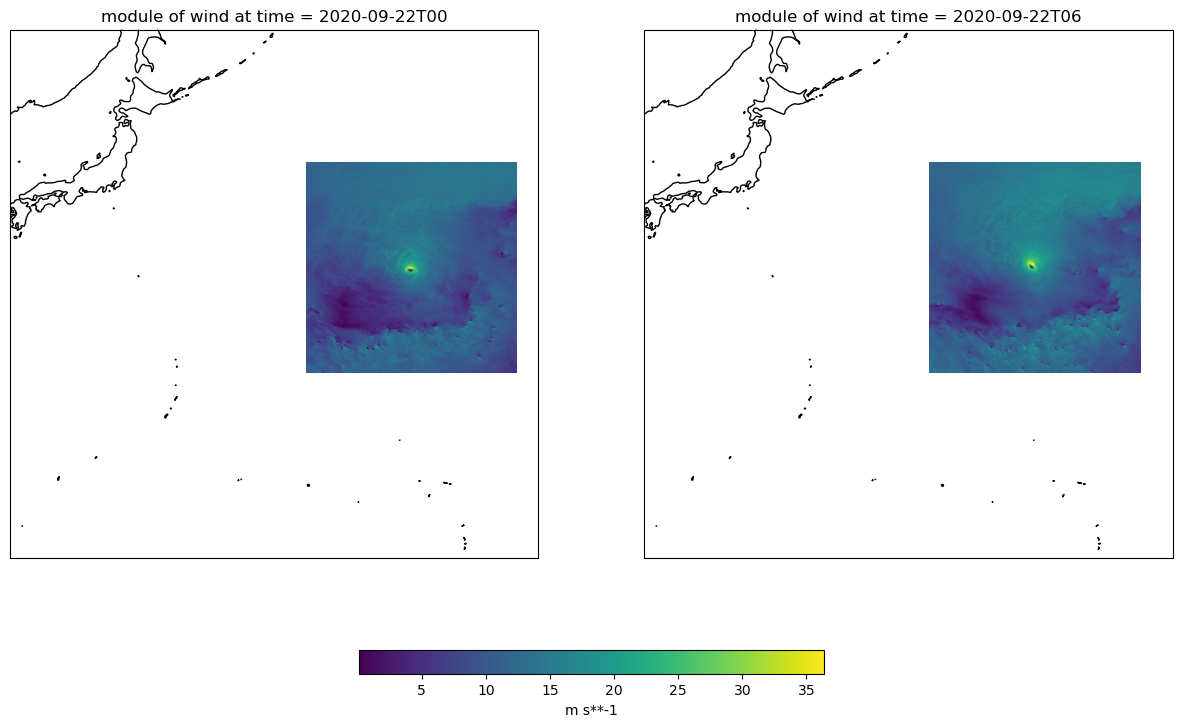

In [4]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
tmpdir='/home/b/b382216/scratch/tmpdir'

# u 10m
tracks_u10 = os.path.join(tmpdir, f'tempest_tracks_U10M.nc')
tracks_u10_file = xr.open_dataset(tracks_u10).isel(time=[24,25,26])['U10M']

# v 10m
tracks_v10 = os.path.join(tmpdir, f'tempest_tracks_V10M.nc')
tracks_v10_file = xr.open_dataset(tracks_v10).isel(time=[24,25,26])['V10M']

tracks_nc_file = (tracks_u10_file**2 + tracks_v10_file**2)**0.5

# create 10 subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# loop over subplots and plot different time slices in each one
for i, ax in enumerate(axs):
    tracks_nc_file.isel(time=i).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.set_extent([130, 180, 0, 50], ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title("module of wind at " + f'time = {str(tracks_nc_file.time[i].values)[:13]}')

# add a colorbar
plt.colorbar(ax.collections[0], ax=axs, shrink=0.4, pad=0.1, location='bottom', label=tracks_v10_file.attrs['units'])

#plt.tight_layout()

plt.show()